In [1]:
# some models for text-to-speech (TTS) generation.
# First, a model is used to generate a mel spectrogram from text. Second, a model is used to generate 
# audio from this generated mel spectrogram.

In [2]:
text1="The Computer Research Institute of Montréal (CRIM) is a leading IT expertise centre that generates concrete results as well as a strategic partner in innovation for organizations."

text2="CRIM creates socio-economic value from scientific and technological advances in digital technology through research, development and transfer. Through its applied research activities, CRIM appropriates scientific and technological advances and contributes to the advancement of science. With its customized experimental research and development projects, designed to meet the needs of organizations, CRIM enables them to reduce technological uncertainties and accelerate the commercialization of their products. By transferring cutting-edge knowledge and technologies to organisations, CRIM improves their competitiveness."

text3="CRIM is a non-profit organization whose work is in line with the policies and strategies of its major financial partner, the ministère de l’Économie et de l’Innovation. CRIM has been serving Québec businesses and organizations for over 35 years and continues to play a key role in the economy by developing specialized tools, delivering structuring technologies to its clients and proactively disseminating best practices and the latest digital innovations."

text4="The Computer Research Institute of Montréal (CRIM) is a leading IT expertise centre that generates concrete results as well as a strategic partner in innovation for organizations. CRIM creates socio-economic value from scientific and technological advances in digital technology through research, development and transfer. Through its applied research activities, CRIM appropriates scientific and technological advances and contributes to the advancement of science. With its customized experimental research and development projects, designed to meet the needs of organizations, CRIM enables them to reduce technological uncertainties and accelerate the commercialization of their products. By transferring cutting-edge knowledge and technologies to organisations, CRIM improves their competitiveness. CRIM is a non-profit organization whose work is in line with the policies and strategies of its major financial partner, the ministère de l’Économie et de l’Innovation. CRIM has been serving Québec businesses and organizations for over 35 years and continues to play a key role in the economy by developing specialized tools, delivering structuring technologies to its clients and proactively disseminating best practices and the latest digital innovations."

text5="competitiveness"

text6="35 years"

text7="35"

text8="Directing Connie to the house would be difficult, but Lisa could wait at the end of the drive."

text9="Marking the damp wall with chalk proved difficult, but they were satisfied the arrows were legible."

text10="He blinked, went red, got up and sat down again, struggling with himself to do what was for him the most difficult thing in life--to say an unpleasant thing to a man's face, to say what the other, whoever he might be, did not expect."

text11="He asked Weyrother several times to repeat words he had not clearly heard and the difficult names of villages."

#Tongue twisters

text12="The sixth sick Sheik's sixth sheep's sick."

text13="An ape hates grape cakes."

text14="A tutor who tooted the flute tried to tutor two tooters to toot...."

text15="These thousand tricky tongue twisters trip thrillingly off the tongue."

text16="Six thick thistle sticks. ..."

text17="Pad kid poured curd pulled cod."

text18="Top chopstick shops stock top chopsticks."

In [3]:
# Import NeMo and it's ASR, NLP and TTS collections
import nemo
# Import Speech Synthesis collection
import nemo.collections.tts as nemo_tts
# We'll use this to listen to audio
import IPython

[NeMo W 2022-04-07 12:56:49 optimizers:55] Apex was not found. Using the lamb or fused_adam optimizer will error out.
[NeMo W 2022-04-07 12:56:51 experimental:27] Module <class 'nemo.collections.nlp.data.language_modeling.megatron.megatron_batch_samplers.MegatronPretrainingRandomBatchSampler'> is experimental, not ready for production and is not fully supported. Use at your own risk.


In [4]:
tts_models = [model for model in dir(nemo_tts.models) if model.endswith("Model")]
tts_models

['AlignerModel',
 'DegliModel',
 'EDMel2SpecModel',
 'FastPitchHifiGanE2EModel',
 'FastPitchModel',
 'FastSpeech2HifiGanE2EModel',
 'FastSpeech2Model',
 'GlowTTSModel',
 'GriffinLimModel',
 'HifiGanModel',
 'MelGanModel',
 'MelPsuedoInverseModel',
 'MixerTTSModel',
 'SqueezeWaveModel',
 'Tacotron2Model',
 'TalkNetDursModel',
 'TalkNetPitchModel',
 'TalkNetSpectModel',
 'TwoStagesModel',
 'UniGlowModel',
 'UnivNetModel',
 'WaveGlowModel']

In [5]:
from omegaconf import OmegaConf, open_dict
import torch
#from nemo.collections.asr.parts import parsers
from nemo.collections.tts.models.base import SpectrogramGenerator, Vocoder
import os
from IPython.display import Audio
# Generate audio
import soundfile as sf
import IPython.display as ipd
import numpy as np
from PIL import Image
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt
%matplotlib inline


def infer(spec_gen_model, vocder_model, str_input):
    with torch.no_grad():
        parsed = spec_gen.parse(str_input)
        spectrogram = spec_gen.generate_spectrogram(tokens=parsed)
        audio = vocoder.convert_spectrogram_to_audio(spec=spectrogram)
    if isinstance(spectrogram, torch.Tensor):
        spectrogram = spectrogram.to('cpu').numpy()
    if len(spectrogram.shape) == 3:
        spectrogram = spectrogram[0]
    if isinstance(audio, torch.Tensor):
        audio = audio.to('cpu').numpy()
    return spectrogram, audio

def load_spectrogram_model(spectrogram_generator):
    override_conf = None
    if spectrogram_generator == "tacotron2":
        from nemo.collections.tts.models import Tacotron2Model
        spec_generator = Tacotron2Model.from_pretrained(model_name="tts_en_tacotron2")
    elif spectrogram_generator == "glow_tts":
        from nemo.collections.tts.models import GlowTTSModel
        spec_generator = GlowTTSModel.from_pretrained("tts_en_glowtts")
    elif spectrogram_generator == "FastPitch":
        from nemo.collections.tts.models import FastPitchModel
        spec_generator = FastPitchModel.from_pretrained("tts_en_fastpitch")
    elif spectrogram_generator == "MixerTTS":
        from nemo.collections.tts.models import MixerTTSModel
        spec_generator = MixerTTSModel.from_pretrained("tts_en_lj_mixertts")
    else:
        raise NotImplementedError

    return spec_generator


def load_vocoder_model(audio_generator):
    RequestPseudoInverse = False
    TwoStagesModel = False
    
    if audio_generator == "waveglow":
        from nemo.collections.tts.models import WaveGlowModel
        pretrained_model = "tts_waveglow_88m"
    elif audio_generator == "squeezewave":
        from nemo.collections.tts.models import SqueezeWaveModel
        pretrained_model = "tts_squeezewave"
    elif audio_generator == "uniglow":
        from nemo.collections.tts.models import UniGlowModel
        pretrained_model = "tts_uniglow"
    elif audio_generator == "melgan":
        from nemo.collections.tts.models import MelGanModel
        pretrained_model = "tts_melgan"
    elif audio_generator == "hifigan":
        from nemo.collections.tts.models import HifiGanModel
        pretrained_model = "tts_hifigan"
    elif audio_generator == "two_stages":
        from nemo.collections.tts.models import TwoStagesModel
        cfg = {'linvocoder':  {'_target_': 'nemo.collections.tts.models.two_stages.GriffinLimModel',
                             'cfg': {'n_iters': 64, 'n_fft': 1024, 'l_hop': 256}},
               'mel2spec': {'_target_': 'nemo.collections.tts.models.two_stages.MelPsuedoInverseModel',
                           'cfg': {'sampling_rate': 22050, 'n_fft': 1024, 
                                   'mel_fmin': 0, 'mel_fmax': 8000, 'mel_freq': 80}}}
        model = TwoStagesModel(cfg)
        if mel2spec == "encoder_decoder":
            from nemo.collections.tts.models.ed_mel2spec import EDMel2SpecModel
            pretrained_mel2spec_model = "EncoderDecoderMelToSpec-22050Hz"
            mel2spec_model = EDMel2SpecModel.from_pretrained(pretrained_mel2spec_model)
            model.set_mel_to_spec_model(mel2spec_model)

        if linvocoder == "degli":
            from nemo.collections.tts.models.degli import DegliModel
            pretrained_linvocoder_model = "DeepGriffinLim-22050Hz"
            linvocoder_model = DegliModel.from_pretrained(pretrained_linvocoder_model)
            model.set_linear_vocoder(linvocoder_model)
            
        TwoStagesModel = True

    else:
        raise NotImplementedError

    if not TwoStagesModel:
        model = Vocoder.from_pretrained(pretrained_model)
    return model

In [6]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
import logging, sys
logging.disable(sys.maxsize)

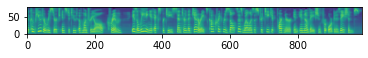

In [7]:
text_to_generate = text1
spectrogram_generator = "FastPitch"
audio_generator = "waveglow"

sample_rate=22050

spec_gen = load_spectrogram_model(spectrogram_generator) #.cuda()
vocoder = load_vocoder_model(audio_generator)

spec, audio = infer(spec_gen, vocoder, text_to_generate)
imshow(spec, origin="lower")
plt.show()

# Save the audio to disk in a file called speech_example.wav
#expect the data in (frames, channels) format
sf.write("speech_example.wav", audio.transpose(), sample_rate)

Audio(audio, rate = sample_rate)

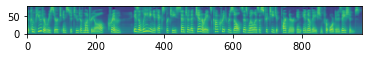

In [8]:
text_to_generate = text1
spectrogram_generator = "FastPitch"
audio_generator = "hifigan"

sample_rate=22050

spec_gen = load_spectrogram_model(spectrogram_generator) #.cuda()
vocoder = load_vocoder_model(audio_generator)

spec, audio = infer(spec_gen, vocoder, text_to_generate)
imshow(spec, origin="lower")
plt.show()

# Save the audio to disk in a file called speech_example.wav
#expect the data in (frames, channels) format
sf.write("speech_example.wav", audio.transpose(), sample_rate)

Audio(audio, rate = sample_rate)

# Generation using tacotron2 waveglow...


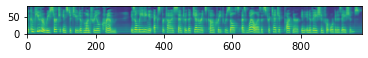

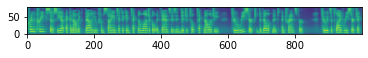

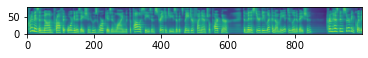

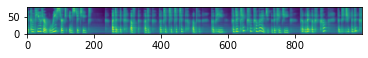

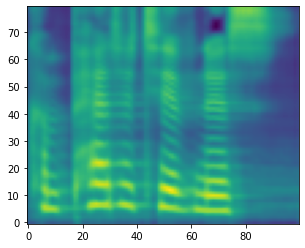

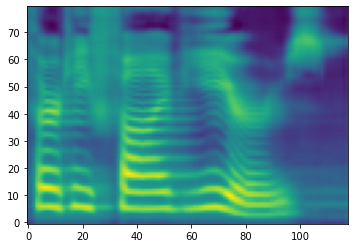

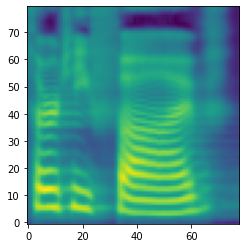

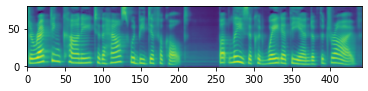

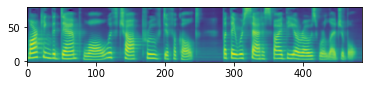

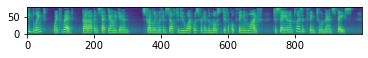

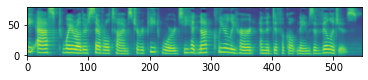

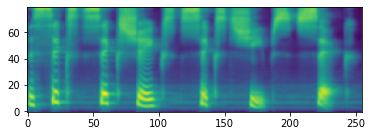

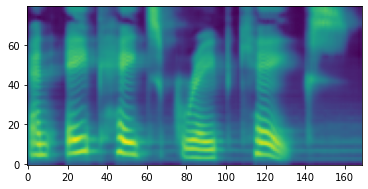

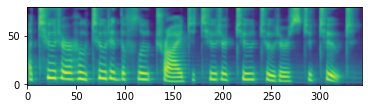

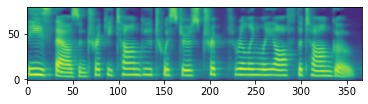

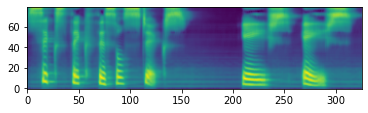

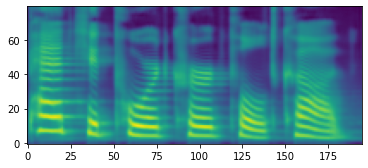

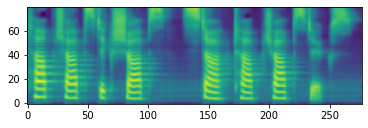

# Generation using glow_tts waveglow...
## Issue: waveglow glow_tts
# Generation using FastPitch waveglow...


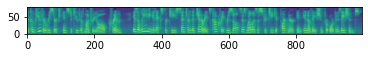

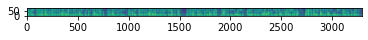

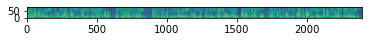

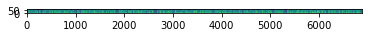

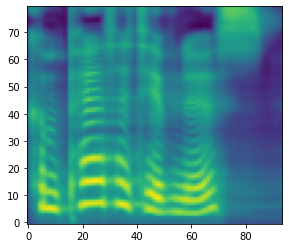

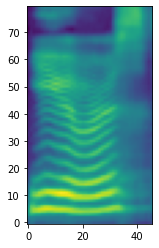

## Phrase not generated: 35


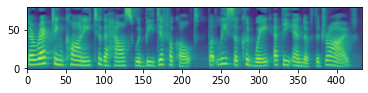

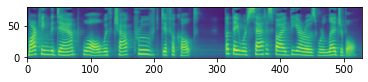

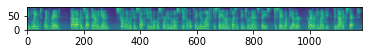

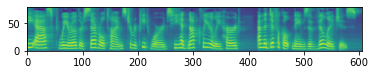

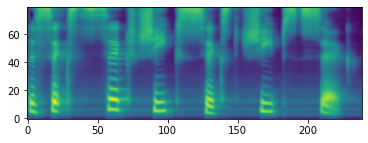

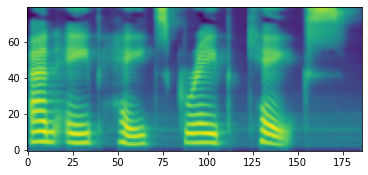

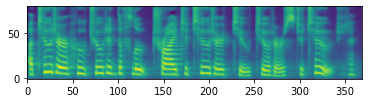

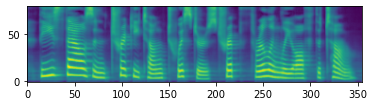

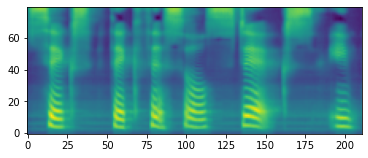

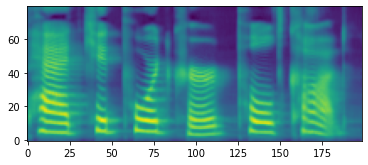

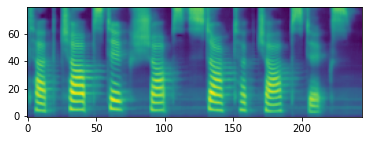

# Generation using tacotron2 squeezewave...
## Issue: squeezewave tacotron2
# Generation using glow_tts squeezewave...
## Issue: squeezewave glow_tts
# Generation using FastPitch squeezewave...
## Issue: squeezewave FastPitch
# Generation using tacotron2 uniglow...
## Issue: uniglow tacotron2
# Generation using glow_tts uniglow...
## Issue: uniglow glow_tts
# Generation using FastPitch uniglow...
## Issue: uniglow FastPitch
# Generation using tacotron2 melgan...


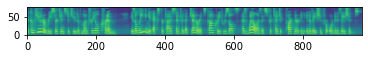

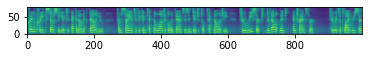

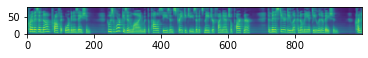

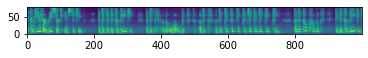

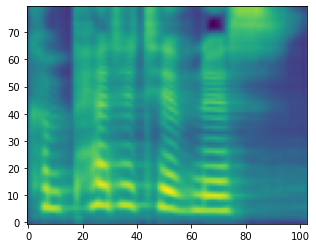

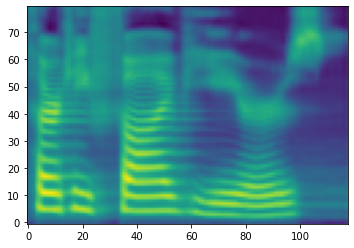

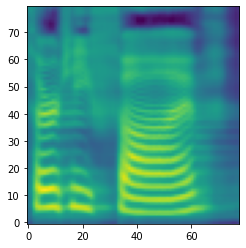

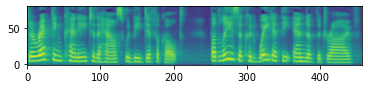

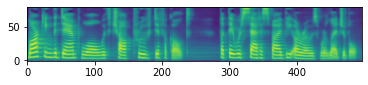

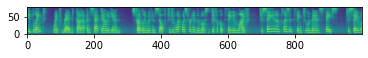

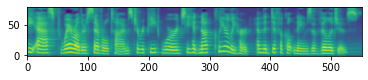

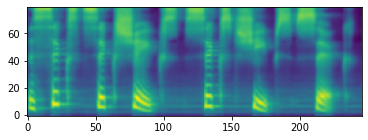

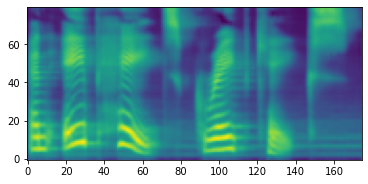

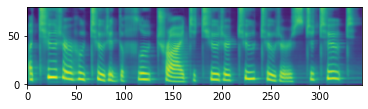

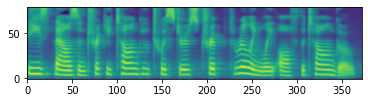

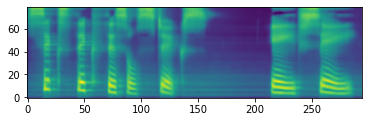

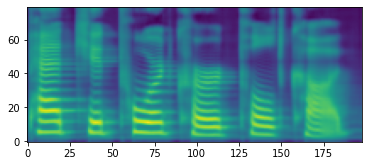

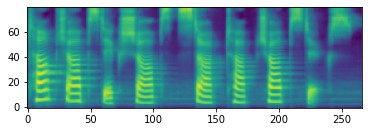

# Generation using glow_tts melgan...
## Issue: melgan glow_tts
# Generation using FastPitch melgan...


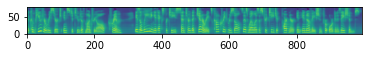

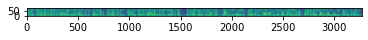

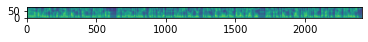

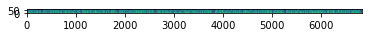

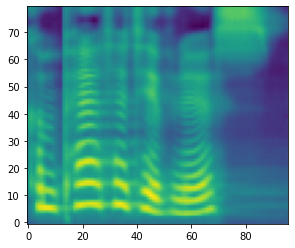

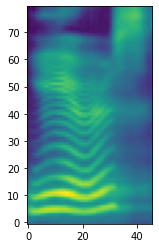

## Phrase not generated: 35


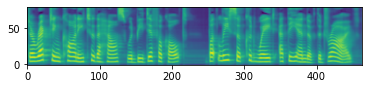

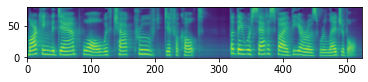

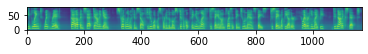

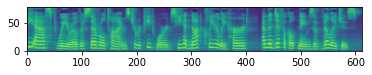

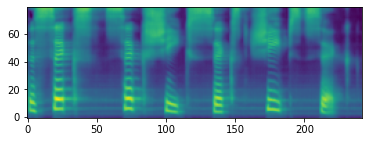

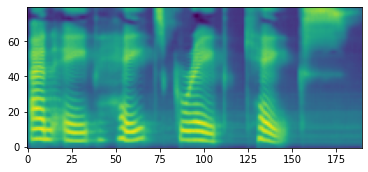

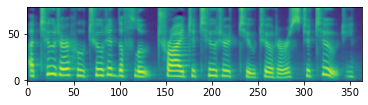

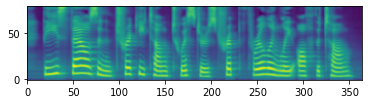

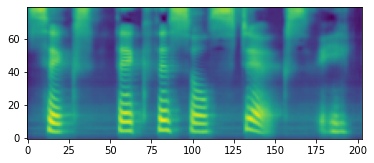

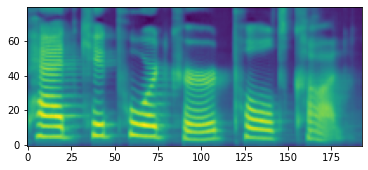

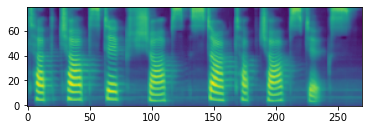

# Generation using tacotron2 hifigan...


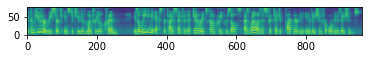

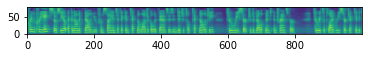

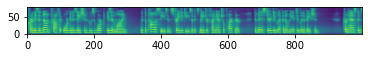

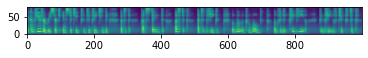

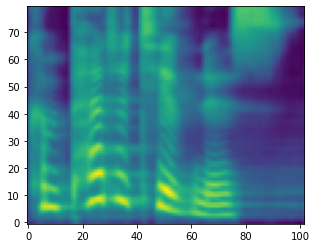

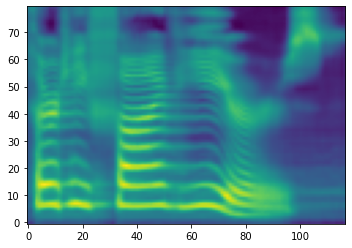

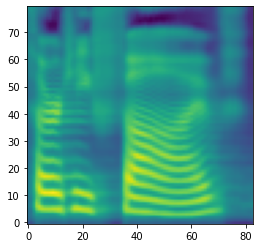

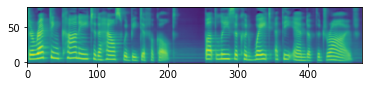

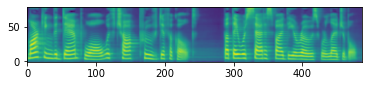

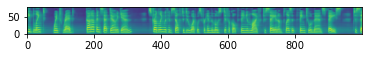

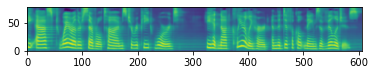

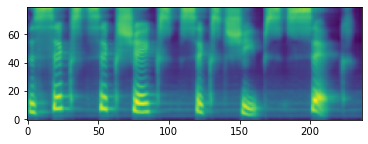

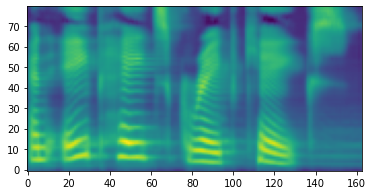

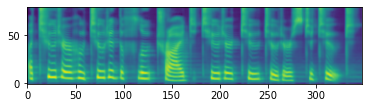

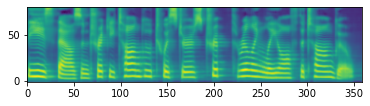

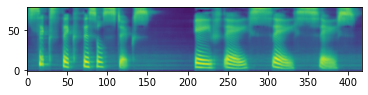

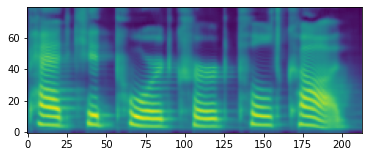

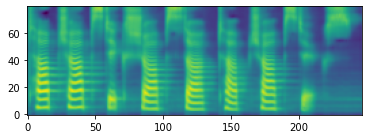

# Generation using glow_tts hifigan...
## Issue: hifigan glow_tts
# Generation using FastPitch hifigan...


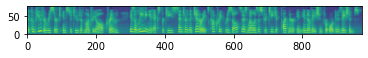

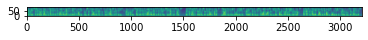

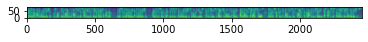

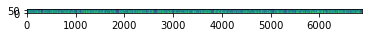

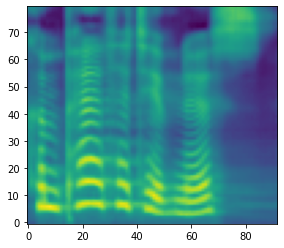

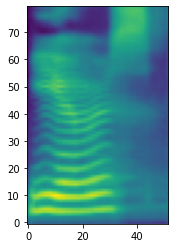

## Phrase not generated: 35


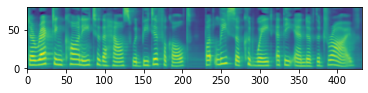

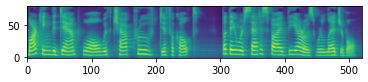

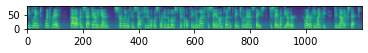

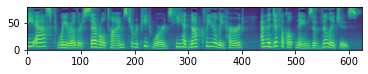

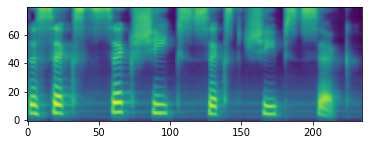

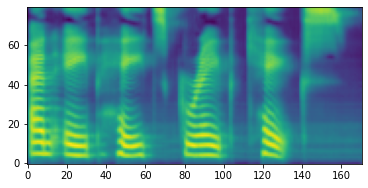

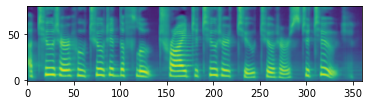

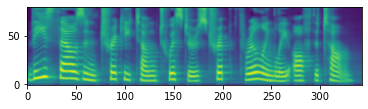

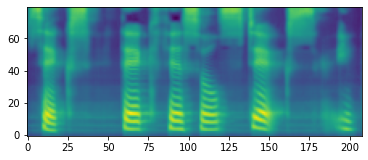

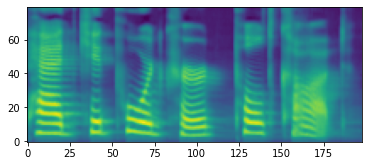

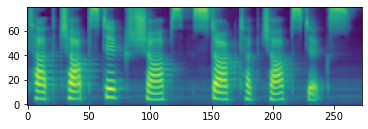

# Generation using tacotron2 two_stages...


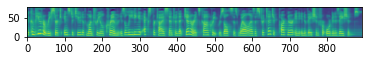

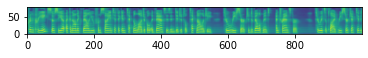

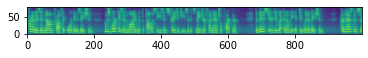

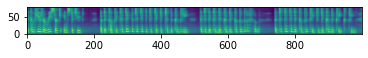

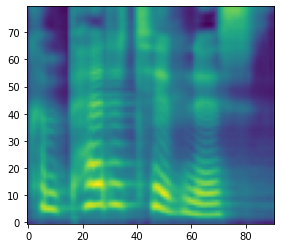

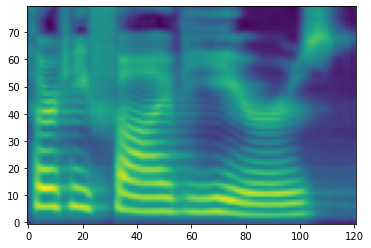

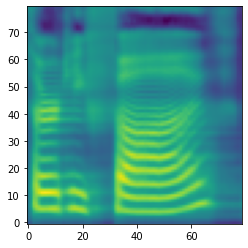

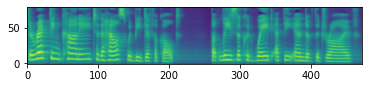

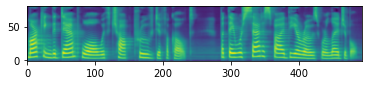

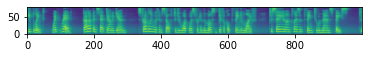

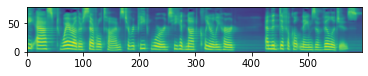

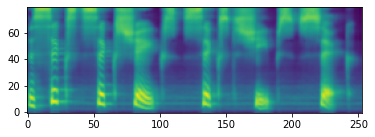

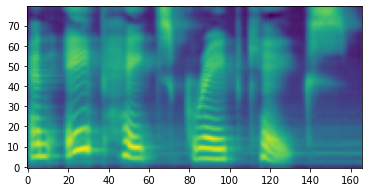

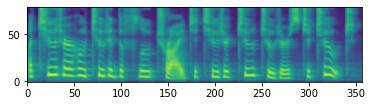

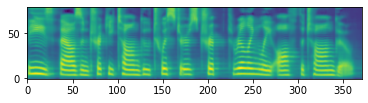

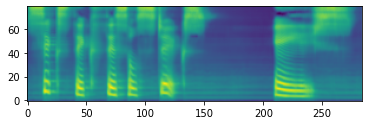

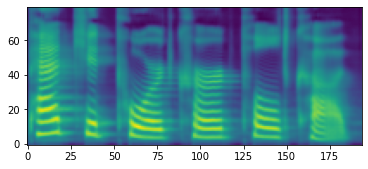

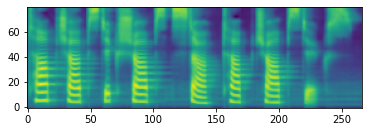

# Generation using glow_tts two_stages...
## Issue: two_stages glow_tts psuedo_inverse griffin_lim
# Generation using FastPitch two_stages...


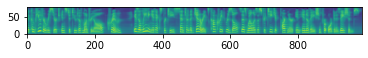

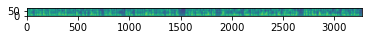

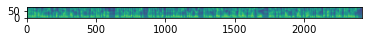

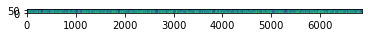

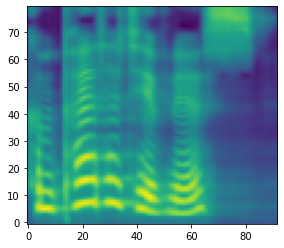

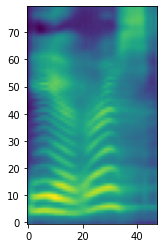

## Phrase not generated: 35


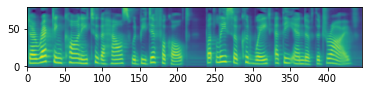

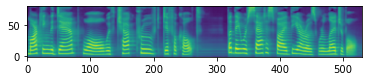

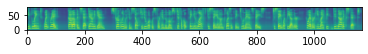

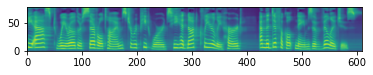

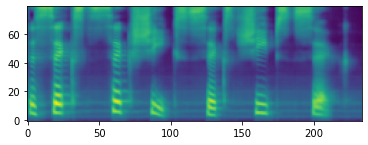

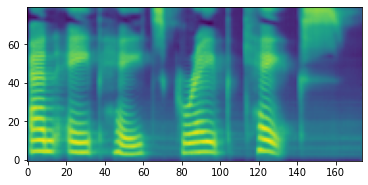

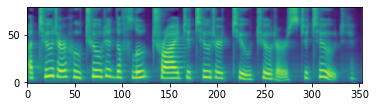

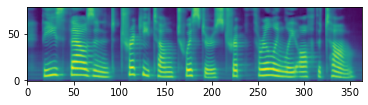

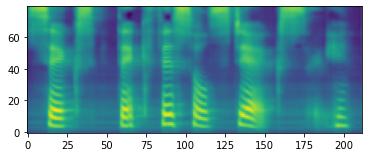

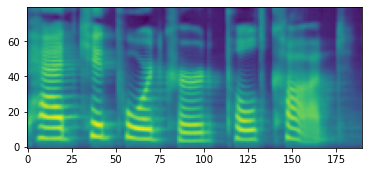

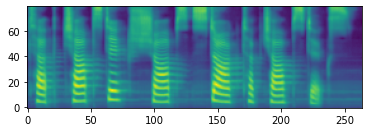

In [9]:
supported_spec_gen = ["tacotron2", "glow_tts", "FastPitch"]
supported_audio_gen = ["waveglow", "squeezewave", "uniglow", "melgan", "hifigan", "two_stages"]
mel2spec_models = ["psuedo_inverse", "encoder_decoder"]
linvocoders = ["griffin_lim", "degli"]

list_texts_to_generate = [text1,text2,text3,text4,text5,text6,text7,text8,text9,text10,text11,text12,text13,text14,text15,text16,text17,text18]

for audio_generator in supported_audio_gen:
    for spectrogram_generator in supported_spec_gen:
        if audio_generator=="two_stages":
            mel2spec = "psuedo_inverse"
            linvocoder = "griffin_lim"
        print("# Generation using " + spectrogram_generator + " " + audio_generator + "...")
        try:
            spec_gen = load_spectrogram_model(spectrogram_generator) #.cuda()
            vocoder = load_vocoder_model(audio_generator) #.cuda()

            if audio_generator=="two_stages":
                models_repo="generated_samples_tts_" + spectrogram_generator + "_" + audio_generator + "_" + mel2spec + "_" + linvocoder + "/"
            else:
                models_repo="generated_samples_tts_" + spectrogram_generator + "_" + audio_generator + "/"

            os.makedirs(models_repo, exist_ok=True)

            for idx,text_to_generate in enumerate(list_texts_to_generate):
                try:
                    spec, audio = infer(spec_gen, vocoder, text_to_generate)
                    imshow(spec, origin="lower")
                    plt.show()

                    # Save the audio to disk in a file called speech.wav
                    #expect the data in (frames, channels) format
                    sf.write(models_repo + "speech" + str(idx+1) + ".wav", audio.transpose(), sample_rate)

                    Audio(audio, rate = sample_rate)
                except:
                    print("## Phrase not generated: " + text_to_generate)
        except:
            if audio_generator=="two_stages": 
                print("## Issue: "+ audio_generator + " " + spectrogram_generator + " " + mel2spec + " " + linvocoder)
            else:
                print("## Issue: "+ audio_generator + " " + spectrogram_generator)

In [10]:
nemo_tts.models.Tacotron2Model.list_available_models()

[PretrainedModelInfo(
 	pretrained_model_name=tts_en_tacotron2,
 	description=This model is trained on LJSpeech sampled at 22050Hz, and can be used to generate female English voices with an American accent.,
 	location=https://api.ngc.nvidia.com/v2/models/nvidia/nemo/tts_en_tacotron2/versions/1.0.0/files/tts_en_tacotron2.nemo,
 	class_=<class 'nemo.collections.tts.models.tacotron2.Tacotron2Model'>
 )]

In [11]:
nemo_tts.models.WaveGlowModel.list_available_models()

[PretrainedModelInfo(
 	pretrained_model_name=tts_waveglow_268m,
 	description=This model is trained on LJSpeech sampled at 22050Hz, and has been tested on generating female English voices with an American accent and Mandarin voices.,
 	location=https://api.ngc.nvidia.com/v2/models/nvidia/nemo/tts_waveglow_268m/versions/1.0.0rc1/files/tts_waveglow_268m.nemo,
 	class_=<class 'nemo.collections.tts.models.waveglow.WaveGlowModel'>
 ),
 PretrainedModelInfo(
 	pretrained_model_name=tts_waveglow_88m,
 	description=This model is trained on LJSpeech sampled at 22050Hz, and has been tested on generating female English voices with an American accent and Mandarin voices.,
 	location=https://api.ngc.nvidia.com/v2/models/nvidia/nemo/tts_waveglow_88m/versions/1.0.0/files/tts_waveglow.nemo,
 	class_=<class 'nemo.collections.tts.models.waveglow.WaveGlowModel'>
 )]

In [12]:
from nemo.collections.tts.models import HifiGanModel
HifiGanModel.list_available_models()

[PretrainedModelInfo(
 	pretrained_model_name=tts_hifigan,
 	description=This model is trained on LJSpeech audio sampled at 22050Hz and mel spectrograms generated from Tacotron2, TalkNet, and FastPitch. This model has been tested on generating female English voices with an American accent.,
 	location=https://api.ngc.nvidia.com/v2/models/nvidia/nemo/tts_hifigan/versions/1.0.0rc1/files/tts_hifigan.nemo,
 	class_=<class 'nemo.collections.tts.models.hifigan.HifiGanModel'>
 ),
 PretrainedModelInfo(
 	pretrained_model_name=tts_en_lj_hifigan_ft_mixertts,
 	description=This model is trained on LJSpeech audio sampled at 22050Hz and mel spectrograms generated from Mixer-TTS. This model has been tested on generating female English voices with an American accent.,
 	location=https://api.ngc.nvidia.com/v2/models/nvidia/nemo/tts_en_lj_hifigan/versions/1.6.0/files/tts_en_lj_hifigan_ft_mixertts.nemo,
 	class_=<class 'nemo.collections.tts.models.hifigan.HifiGanModel'>
 ),
 PretrainedModelInfo(
 	pretr

In [ ]:
# Install required packages
"""conda create --name envTTS python=3.8
conda activate envTTS
conda install jupyter notebook
pip install git+https://github.com/NVIDIA/NeMo.git
conda install -c conda-forge pydub
pip install opencv-python
conda install -c conda-forge librosa
pip install Cython
pip install nemo_toolkit['all']
pip install editdistance
pip install wget unidecode
pip install pynini"""